## Importación de paquetes

In [85]:
# necessary imports 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import statsmodels.formula.api as smf
import shap
import js2py
import xgboost as xgb
import graphviz
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from statsmodels.formula.api import glm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from scipy.stats import poisson, gamma, expon, kstest
from shap import Explainer, Explanation

# import warnings
# warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

plt.style.use('ggplot')

In [202]:
# Recuperación de objetos de ejecuciones anteriores

%store -r DensidadPoblacion
%store -r pg17trainpoldens
%store -r vh_make_group_dic
%store -r pg17trainclaim_group
%store -r pg17trainpolclaims
%store -r pg17trainpolclaims_pre
%store -r pg17trainpolclaims_pre2
%store -r pg17trainpolclaims_dum
%store -r dist_y_train
%store -r dist_y_test
%store -r dist_y
%store -r modelo_glm_Poisson
%store -r resultado_modelo_glm_Poisson
%store -r y_pred_glm_Poisson_train
%store -r y_pred_glm_Poisson_test
%store -r modelo_glm_Gamma
%store -r resultado_modelo_glm_Gamma
%store -r y_pred_glm_Gamma_train
%store -r y_pred_glm_Gamma_test
%store -r glm_Poisson_shap_values

## Importación de ficheros

In [3]:
pg17trainpol = pd.read_csv('dataset/claims/pg17trainpol.csv')
pg17trainclaim = pd.read_csv('dataset/claims/pg17trainclaim.csv')
# pg17testyear1 = pd.read_csv('dataset/claims/pg17testyear1.csv')
# pg17testyear2 = pd.read_csv('dataset/claims/pg17testyear2.csv')
# pg17testyear3 = pd.read_csv('dataset/claims/pg17testyear3.csv')
# pg17testyear4 = pd.read_csv('dataset/claims/pg17testyear4.csv')
DensidadPoblacion = pd.read_csv('dataset/claims/DensidadPoblacion.csv')

In [4]:
pg17trainpol

,id_client,id_vehicle,id_policy,id_year,pol_bonus,pol_coverage,pol_duration,pol_sit_duration,pol_pay_freq,pol_payd,pol_usage,pol_insee_code,drv_drv2,drv_age1,drv_age2,drv_sex1,drv_sex2,drv_age_lic1,drv_age_lic2,vh_age,vh_cyl,vh_din,vh_fuel,vh_make,vh_model,vh_sale_begin,vh_sale_end,vh_speed,vh_type,vh_value,vh_weight
0,A00000001,V01,A00000001-V01,Year 0,0.5,Maxi,29,9,Biannual,No,Retired,36233,No,85,0,M,NaN,62,0,10.0,1587,98,Gasoline,PEUGEOT,306,10,9,182,Tourism,20700,1210
1,A00000002,V01,A00000002-V01,Year 0,0.5,Maxi,3,1,Biannual,No,Retired,92073,No,69,0,M,NaN,39,0,4.0,2149,170,Diesel,MERCEDES BENZ,C220,4,2,229,Tourism,34250,1510
2,A00000003,V01,A00000003-V01,Year 0,0.5,Maxi,2,2,Yearly,No,WorkPrivate,92026,No,37,0,M,NaN,18,0,11.0,1991,150,Gasoline,BMW,Z3,12,11,210,Tourism,28661,1270
3,A00000004,V01,A00000004-V01,Year 0,0.5,Median2,22,1,Yearly,No,WorkPrivate,78537,Yes,81,21,M,F,54,3,16.0,1781,90,Gasoline,VOLKSWAGEN,GOLF,18,15,180,Tourism,14407,1020
4,A00000005,V01,A00000005-V01,Year 0,0.5,Maxi,16,4,Biannual,No,Retired,38544,Yes,62,68,F,M,37,48,11.0,1598,108,Gasoline,RENAULT,LAGUNA,13,11,195,Tourism,16770,1230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,A00091485,V01,A00091485-V01,Year 0,0.5,Maxi,7,4,Biannual,No,Retired,90010,No,65,0,M,NaN,46,0,14.0,2499,75,Diesel,RENAULT,MASTER,15,13,130,Commercial,24269,0
99996,A00091485,V02,A00091485-V02,Year 0,0.5,Maxi,4,2,Biannual,No,Retired,90010,No,65,0,M,NaN,46,0,15.0,1761,111,Gasoline,CITROEN,XANTIA,15,13,192,Tourism,18050,1234
99997,A00091486,V01,A00091486-V01,Year 0,0.5,Maxi,6,6,Monthly,No,Professional,82025,Yes,65,67,M,F,45,26,15.0,2874,123,Diesel,MERCEDES BENZ,SPRINTER,16,11,141,Commercial,24416,0
99998,A00091487,V01,A00091487-V01,Year 0,0.5,Maxi,11,5,Biannual,No,WorkPrivate,45234,No,47,0,F,NaN,28,0,5.0,1242,66,Gasoline,FIAT,PUNTO,6,4,155,Tourism,10950,1015


In [5]:
pg17trainpol.describe()

,pol_bonus,pol_duration,pol_sit_duration,drv_age1,drv_age2,drv_age_lic1,drv_age_lic2,vh_age,vh_cyl,vh_din,vh_sale_begin,vh_sale_end,vh_speed,vh_value,vh_weight
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,99999.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000
mean,0.537337,11.081790,2.733490,54.683820,15.581220,32.489850,9.125290,9.551956,1645.883360,91.39245,11.653720,8.673170,170.683010,18058.69148,1128.207520
std,0.098050,8.553126,2.364288,14.871759,24.003759,13.465298,16.997527,7.027118,461.929974,34.31132,7.789755,6.643753,23.367833,8663.26866,360.640938
min,0.500000,1.000000,1.000000,19.000000,0.000000,1.000000,0.000000,1.000000,0.000000,13.00000,1.000000,1.000000,25.000000,0.00000,0.000000
25%,0.500000,4.000000,1.000000,43.000000,0.000000,22.000000,0.000000,4.000000,1360.000000,68.00000,6.000000,4.000000,157.000000,11950.00000,950.000000
50%,0.500000,9.000000,2.000000,54.000000,0.000000,33.000000,0.000000,8.000000,1587.000000,87.00000,10.000000,7.000000,170.000000,16229.50000,1130.000000
75%,0.500000,16.000000,3.000000,65.000000,34.000000,42.000000,15.000000,13.000000,1910.000000,109.00000,15.000000,12.000000,185.000000,22106.00000,1320.000000
max,2.160000,41.000000,25.000000,103.000000,99.000000,111.000000,111.000000,66.000000,6997.000000,555.00000,74.000000,55.000000,310.000000,155498.00000,7901.000000


In [6]:
pg17trainpol.describe(include='object')

,id_client,id_vehicle,id_policy,id_year,pol_coverage,pol_pay_freq,pol_payd,pol_usage,pol_insee_code,drv_drv2,drv_sex1,drv_sex2,vh_fuel,vh_make,vh_model,vh_type
count,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,33186,100000,100000,100000,100000
unique,91488,9,100000,1,4,4,2,4,17794,2,2,2,3,101,1023,2
top,A00054291,V01,A00000001-V01,Year 0,Maxi,Yearly,No,WorkPrivate,31555,No,M,F,Diesel,RENAULT,CLIO,Tourism
freq,9,91488,1,100000,64515,37733,95848,66015,511,66814,60201,20332,54872,26795,7287,90151


In [7]:
pg17trainpol.dtypes

id_client            object
id_vehicle           object
id_policy            object
id_year              object
pol_bonus           float64
pol_coverage         object
pol_duration          int64
pol_sit_duration      int64
pol_pay_freq         object
pol_payd             object
pol_usage            object
pol_insee_code       object
drv_drv2             object
drv_age1              int64
drv_age2              int64
drv_sex1             object
drv_sex2             object
drv_age_lic1          int64
drv_age_lic2          int64
vh_age              float64
vh_cyl                int64
vh_din                int64
vh_fuel              object
vh_make              object
vh_model             object
vh_sale_begin         int64
vh_sale_end           int64
vh_speed              int64
vh_type              object
vh_value              int64
vh_weight             int64
dtype: object

In [8]:
pg17trainclaim

,id_client,id_vehicle,id_year,id_claim,claim_nb,claim_amount
0,A00000009,V01,Year 0,CL01,1,927.16
1,A00000016,V01,Year 0,CL01,1,555.48
2,A00000026,V01,Year 0,CL01,1,478.01
3,A00000040,V01,Year 0,CL01,1,512.83
4,A00000056,V01,Year 0,CL01,1,1236.00
...,...,...,...,...,...,...
14238,A00091459,V01,Year 0,CL01,1,310.79
14239,A00091466,V01,Year 0,CL01,1,856.64
14240,A00091466,V01,Year 0,CL02,1,618.00
14241,A00091468,V01,Year 0,CL01,1,2781.05


In [9]:
pg17trainclaim.describe()

,claim_nb,claim_amount
count,14243.0,14243.000000
mean,1.0,823.183906
std,0.0,2296.000274
min,1.0,-1863.920000
25%,1.0,118.235000
50%,1.0,472.200000
75%,1.0,1192.965000
max,1.0,141828.260000


In [10]:
pg17trainclaim.describe(include = 'object')

,id_client,id_vehicle,id_year,id_claim
count,14243,14243,14243,14243
unique,12529,5,1,6
top,A00033511,V01,Year 0,CL01
freq,6,13186,14243,12654


## Añadimos la densidad de población al dataframe

In [11]:
DensidadPoblacion

,pol_insee_code,pol_insee_description,pol_insee_density
0,01001,L'Abergement-Clémenciat,6
1,01002,L'Abergement-de-Varey,6
2,01004,Ambérieu-en-Bugey,2
3,01005,Ambérieux-en-Dombes,5
4,01006,Ambléon,6
...,...,...,...
34940,97613,M'Tsangamouji,3
34941,97614,Ouangani,3
34942,97615,Pamandzi,2
34943,97616,Sada,2


In [12]:
pg17trainpoldens = pd.merge(pg17trainpol, DensidadPoblacion[['pol_insee_code','pol_insee_density']], how="left", on="pol_insee_code")

In [13]:
pg17trainpoldens

,id_client,id_vehicle,id_policy,id_year,pol_bonus,pol_coverage,pol_duration,pol_sit_duration,pol_pay_freq,pol_payd,pol_usage,pol_insee_code,drv_drv2,drv_age1,drv_age2,drv_sex1,drv_sex2,drv_age_lic1,drv_age_lic2,vh_age,vh_cyl,vh_din,vh_fuel,vh_make,vh_model,vh_sale_begin,vh_sale_end,vh_speed,vh_type,vh_value,vh_weight,pol_insee_density
0,A00000001,V01,A00000001-V01,Year 0,0.5,Maxi,29,9,Biannual,No,Retired,36233,No,85,0,M,NaN,62,0,10.0,1587,98,Gasoline,PEUGEOT,306,10,9,182,Tourism,20700,1210,6.0
1,A00000002,V01,A00000002-V01,Year 0,0.5,Maxi,3,1,Biannual,No,Retired,92073,No,69,0,M,NaN,39,0,4.0,2149,170,Diesel,MERCEDES BENZ,C220,4,2,229,Tourism,34250,1510,1.0
2,A00000003,V01,A00000003-V01,Year 0,0.5,Maxi,2,2,Yearly,No,WorkPrivate,92026,No,37,0,M,NaN,18,0,11.0,1991,150,Gasoline,BMW,Z3,12,11,210,Tourism,28661,1270,1.0
3,A00000004,V01,A00000004-V01,Year 0,0.5,Median2,22,1,Yearly,No,WorkPrivate,78537,Yes,81,21,M,F,54,3,16.0,1781,90,Gasoline,VOLKSWAGEN,GOLF,18,15,180,Tourism,14407,1020,3.0
4,A00000005,V01,A00000005-V01,Year 0,0.5,Maxi,16,4,Biannual,No,Retired,38544,Yes,62,68,F,M,37,48,11.0,1598,108,Gasoline,RENAULT,LAGUNA,13,11,195,Tourism,16770,1230,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,A00091485,V01,A00091485-V01,Year 0,0.5,Maxi,7,4,Biannual,No,Retired,90010,No,65,0,M,NaN,46,0,14.0,2499,75,Diesel,RENAULT,MASTER,15,13,130,Commercial,24269,0,1.0
99996,A00091485,V02,A00091485-V02,Year 0,0.5,Maxi,4,2,Biannual,No,Retired,90010,No,65,0,M,NaN,46,0,15.0,1761,111,Gasoline,CITROEN,XANTIA,15,13,192,Tourism,18050,1234,1.0
99997,A00091486,V01,A00091486-V01,Year 0,0.5,Maxi,6,6,Monthly,No,Professional,82025,Yes,65,67,M,F,45,26,15.0,2874,123,Diesel,MERCEDES BENZ,SPRINTER,16,11,141,Commercial,24416,0,6.0
99998,A00091487,V01,A00091487-V01,Year 0,0.5,Maxi,11,5,Biannual,No,WorkPrivate,45234,No,47,0,F,NaN,28,0,5.0,1242,66,Gasoline,FIAT,PUNTO,6,4,155,Tourism,10950,1015,1.0


## Añadimos la agrupación de la marca del vehículo

In [14]:
#Creamos el diccionario para agrupar las marcas de los vehículos

vh_make_group_dic = {'MERCEDES BENZ' : 'GERMANY', 'BMW' : 'GERMANY', 'VOLKSWAGEN' : 'GERMANY', 'AUDI' : 'GERMANY', 'SEAT' : 'GERMANY', 'SMART' : 'GERMANY', 'PORSCHE' : 'GERMANY', 'MINI' : 'GERMANY', 'SKODA' : 'GERMANY', 'BENTLEY' : 'GERMANY', 'DAIMLER' : 'GERMANY', 'UNIMOG' : 'GERMANY', 'VW PORSCHE' : 'GERMANY', 'NSU' : 'GERMANY', 'JAGUAR' : 'ASIA', 'VOLVO' : 'ASIA', 'LAND ROVER' : 'ASIA', 'ROVER' : 'ASIA', 'LADA VAZ' : 'ASIA', 'MG' : 'ASIA', 'LOTUS' : 'ASIA', 'MAHINDRA' : 'ASIA', 'PININFARINA' : 'ASIA', 'LDV' : 'ASIA', 'APAL' : 'ASIA', 'FORD' : 'USA', 'BEDFORD' : 'USA', 'CHEVROLET' : 'USA', 'DAEWOO' : 'USA', 'PONTIAC' : 'USA', 'HUMMER' : 'USA', 'DAF' : 'USA', 'GME' : 'USA', 'CORVETTE' : 'USA', 'CADILLAC' : 'USA', 'BUICK' : 'USA', 'RILEY' : 'USA', 'SANTANA' : 'EUROPE', 'IVECO' : 'EUROPE', 'SAAB' : 'EUROPE', 'UNIC' : 'EUROPE', 'TRIUMPH' : 'EUROPE', 'SAVIEM' : 'EUROPE', 'AUSTIN' : 'EUROPE', 'ARO' : 'EUROPE', 'UMM' : 'EUROPE', 'MORGAN' : 'EUROPE', 'PIAGGIO' : 'EUROPE', 'MORRIS' : 'EUROPE', 'BERTONE' : 'EUROPE', 'AUSTIN HEALEY' : 'EUROPE', 'OM' : 'EUROPE', 'BREMACH' : 'EUROPE', 'FERRARI' : 'EUROPE', 'STEYR PUCH' : 'EUROPE', 'FSO' : 'EUROPE', 'RENAULT' : 'FRANCE', 'DACIA' : 'FRANCE', 'ACL' : 'FRANCE', 'TEILHOL' : 'FRANCE', 'VD 4 ROUES' : 'FRANCE', 'HOTCHKISS' : 'FRANCE', 'PANHARD' : 'FRANCE', 'AUVERLAND' : 'FRANCE', 'ALPINE' : 'FRANCE', 'MEGA' : 'FRANCE', 'COURNIL' : 'FRANCE', 'BABOULIN' : 'FRANCE', 'MATRA' : 'FRANCE', 'LM SOVRA' : 'FRANCE', 'MAZDA' : 'JAPAN', 'KIA' : 'JAPAN', 'TOYOTA' : 'JAPAN', 'SUZUKI' : 'JAPAN', 'HONDA' : 'JAPAN', 'NISSAN' : 'JAPAN', 'LEXUS' : 'JAPAN', 'HYUNDAI' : 'JAPAN', 'MITSUBISHI' : 'JAPAN', 'DAIHATSU' : 'JAPAN', 'SUBARU' : 'JAPAN', 'SSANGYONG' : 'JAPAN', 'INFINITI' : 'JAPAN', 'ISUZU' : 'JAPAN', 'EBRO' : 'JAPAN', 'DATSUN' : 'JAPAN', 'ASIA' : 'JAPAN', 'PEUGEOT' : 'STELLANTIS', 'CITROEN' : 'STELLANTIS', 'OPEL' : 'STELLANTIS', 'FIAT' : 'STELLANTIS', 'CHRYSLER' : 'STELLANTIS', 'LANCIA' : 'STELLANTIS', 'ALFA ROMEO' : 'STELLANTIS', 'JEEP' : 'STELLANTIS', 'DODGE' : 'STELLANTIS', 'WILLYS' : 'STELLANTIS', 'SIMCA' : 'STELLANTIS', 'TALBOT' : 'STELLANTIS', 'AUTOBIANCHI' : 'STELLANTIS', 'MASERATI' : 'STELLANTIS'}

In [15]:
# Crear la nueva columna utilizando el diccionario de mapeo
pg17trainpoldens['vh_make_group'] = pg17trainpoldens['vh_make'].map(vh_make_group_dic)

In [16]:
pg17trainpoldens

,id_client,id_vehicle,id_policy,id_year,pol_bonus,pol_coverage,pol_duration,pol_sit_duration,pol_pay_freq,pol_payd,pol_usage,pol_insee_code,drv_drv2,drv_age1,drv_age2,drv_sex1,drv_sex2,drv_age_lic1,drv_age_lic2,vh_age,vh_cyl,vh_din,vh_fuel,vh_make,vh_model,vh_sale_begin,vh_sale_end,vh_speed,vh_type,vh_value,vh_weight,pol_insee_density,vh_make_group
0,A00000001,V01,A00000001-V01,Year 0,0.5,Maxi,29,9,Biannual,No,Retired,36233,No,85,0,M,NaN,62,0,10.0,1587,98,Gasoline,PEUGEOT,306,10,9,182,Tourism,20700,1210,6.0,STELLANTIS
1,A00000002,V01,A00000002-V01,Year 0,0.5,Maxi,3,1,Biannual,No,Retired,92073,No,69,0,M,NaN,39,0,4.0,2149,170,Diesel,MERCEDES BENZ,C220,4,2,229,Tourism,34250,1510,1.0,GERMANY
2,A00000003,V01,A00000003-V01,Year 0,0.5,Maxi,2,2,Yearly,No,WorkPrivate,92026,No,37,0,M,NaN,18,0,11.0,1991,150,Gasoline,BMW,Z3,12,11,210,Tourism,28661,1270,1.0,GERMANY
3,A00000004,V01,A00000004-V01,Year 0,0.5,Median2,22,1,Yearly,No,WorkPrivate,78537,Yes,81,21,M,F,54,3,16.0,1781,90,Gasoline,VOLKSWAGEN,GOLF,18,15,180,Tourism,14407,1020,3.0,GERMANY
4,A00000005,V01,A00000005-V01,Year 0,0.5,Maxi,16,4,Biannual,No,Retired,38544,Yes,62,68,F,M,37,48,11.0,1598,108,Gasoline,RENAULT,LAGUNA,13,11,195,Tourism,16770,1230,2.0,FRANCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,A00091485,V01,A00091485-V01,Year 0,0.5,Maxi,7,4,Biannual,No,Retired,90010,No,65,0,M,NaN,46,0,14.0,2499,75,Diesel,RENAULT,MASTER,15,13,130,Commercial,24269,0,1.0,FRANCE
99996,A00091485,V02,A00091485-V02,Year 0,0.5,Maxi,4,2,Biannual,No,Retired,90010,No,65,0,M,NaN,46,0,15.0,1761,111,Gasoline,CITROEN,XANTIA,15,13,192,Tourism,18050,1234,1.0,STELLANTIS
99997,A00091486,V01,A00091486-V01,Year 0,0.5,Maxi,6,6,Monthly,No,Professional,82025,Yes,65,67,M,F,45,26,15.0,2874,123,Diesel,MERCEDES BENZ,SPRINTER,16,11,141,Commercial,24416,0,6.0,GERMANY
99998,A00091487,V01,A00091487-V01,Year 0,0.5,Maxi,11,5,Biannual,No,WorkPrivate,45234,No,47,0,F,NaN,28,0,5.0,1242,66,Gasoline,FIAT,PUNTO,6,4,155,Tourism,10950,1015,1.0,STELLANTIS


In [17]:
pg17trainpoldens['vh_make_group'].unique()

array(['STELLANTIS', 'GERMANY', 'FRANCE', 'JAPAN', 'USA', 'ASIA',
       'EUROPE'], dtype=object)

## Añadimos la información de siniestros al dataframe principal

En primer lugar eliminamos del data frame de claims la columna _claim_nb_, pues sólo contiene el valor 1

In [18]:
pg17trainclaim[pg17trainclaim['claim_nb'] != 1]

,id_client,id_vehicle,id_year,id_claim,claim_nb,claim_amount


In [19]:
pg17trainclaim = pg17trainclaim.drop(columns=['claim_nb'])

Eliminamos aquellos siniestros con importe negativo, pues se corresponden con recursos legales que no le han supuesto a la compañía una pérdida de dinero, sino un beneficio.

In [20]:
pg17trainclaim = pg17trainclaim[pg17trainclaim['claim_amount'] > 0]

Agrupamos por póliza para calcular el número de siniestros por póliza y el coste total por póliza

In [21]:
pg17trainclaim[pg17trainclaim['claim_amount'] <= 0]

,id_client,id_vehicle,id_year,id_claim,claim_amount


In [22]:
# Agrupar por las columnas id_client y id_vehicle y calcular el conteo y el valor medio
pg17trainclaim_group = pg17trainclaim.groupby(['id_client', 'id_vehicle']).agg({'claim_amount': ['count', 'mean']})

# Resetear el índice para obtener un DataFrame plano
pg17trainclaim_group.reset_index(inplace=True)

# Renombrar las columnas para mayor claridad
pg17trainclaim_group.columns = ['id_client', 'id_vehicle', 'count_claim_amount', 'mean_claim_amount']

# Mostrar el nuevo DataFrame agrupado
print(pg17trainclaim_group)

       id_client id_vehicle  count_claim_amount  mean_claim_amount
0      A00000009        V01                   1             927.16
1      A00000016        V01                   1             555.48
2      A00000026        V01                   1             478.01
3      A00000040        V01                   1             512.83
4      A00000056        V01                   1            1236.00
...          ...        ...                 ...                ...
11177  A00091457        V01                   1            1236.00
11178  A00091459        V01                   1             310.79
11179  A00091466        V01                   2             737.32
11180  A00091468        V01                   1            2781.05
11181  A00091476        V01                   1            1236.00

[11182 rows x 4 columns]


In [23]:
# Verificar duplicados después de agrupar
duplicados_despues_agrupar = pg17trainpoldens.groupby(['id_client', 'id_vehicle']).size().reset_index(name='count')
duplicados_despues_agrupar = duplicados_despues_agrupar[duplicados_despues_agrupar['count'] > 1]

# Mostrar los duplicados después de agrupar
print("Duplicados después de agrupar:")
print(duplicados_despues_agrupar)

# Verificar duplicados en todo el DataFrame
duplicados_en_todo_dataframe = pg17trainpoldens.duplicated(subset=['id_client', 'id_vehicle'])
duplicados_en_todo_dataframe = pg17trainpoldens[duplicados_en_todo_dataframe]

# Mostrar los duplicados en todo el DataFrame
print("\nDuplicados en todo el DataFrame:")
print(duplicados_en_todo_dataframe)

Duplicados después de agrupar:
Empty DataFrame
Columns: [id_client, id_vehicle, count]
Index: []

Duplicados en todo el DataFrame:
Empty DataFrame
Columns: [id_client, id_vehicle, id_policy, id_year, pol_bonus, pol_coverage, pol_duration, pol_sit_duration, pol_pay_freq, pol_payd, pol_usage, pol_insee_code, drv_drv2, drv_age1, drv_age2, drv_sex1, drv_sex2, drv_age_lic1, drv_age_lic2, vh_age, vh_cyl, vh_din, vh_fuel, vh_make, vh_model, vh_sale_begin, vh_sale_end, vh_speed, vh_type, vh_value, vh_weight, pol_insee_density, vh_make_group]
Index: []


In [24]:
# Realizar la fusión (merge) en las columnas 'id_client' y 'id_vehicle'
pg17trainpolclaims = pd.merge(pg17trainpoldens, pg17trainclaim_group, on=['id_client', 'id_vehicle'], how='left')

# Rellenar los valores NaN con 0
pg17trainpolclaims['count_claim_amount'].fillna(0, inplace=True)
pg17trainpolclaims['mean_claim_amount'].fillna(0, inplace=True)

# Mostrar el resultado de la fusión
pg17trainpolclaims

,id_client,id_vehicle,id_policy,id_year,pol_bonus,pol_coverage,pol_duration,pol_sit_duration,pol_pay_freq,pol_payd,pol_usage,pol_insee_code,drv_drv2,drv_age1,drv_age2,drv_sex1,drv_sex2,drv_age_lic1,drv_age_lic2,vh_age,vh_cyl,vh_din,vh_fuel,vh_make,vh_model,vh_sale_begin,vh_sale_end,vh_speed,vh_type,vh_value,vh_weight,pol_insee_density,vh_make_group,count_claim_amount,mean_claim_amount
0,A00000001,V01,A00000001-V01,Year 0,0.5,Maxi,29,9,Biannual,No,Retired,36233,No,85,0,M,NaN,62,0,10.0,1587,98,Gasoline,PEUGEOT,306,10,9,182,Tourism,20700,1210,6.0,STELLANTIS,0.0,0.0
1,A00000002,V01,A00000002-V01,Year 0,0.5,Maxi,3,1,Biannual,No,Retired,92073,No,69,0,M,NaN,39,0,4.0,2149,170,Diesel,MERCEDES BENZ,C220,4,2,229,Tourism,34250,1510,1.0,GERMANY,0.0,0.0
2,A00000003,V01,A00000003-V01,Year 0,0.5,Maxi,2,2,Yearly,No,WorkPrivate,92026,No,37,0,M,NaN,18,0,11.0,1991,150,Gasoline,BMW,Z3,12,11,210,Tourism,28661,1270,1.0,GERMANY,0.0,0.0
3,A00000004,V01,A00000004-V01,Year 0,0.5,Median2,22,1,Yearly,No,WorkPrivate,78537,Yes,81,21,M,F,54,3,16.0,1781,90,Gasoline,VOLKSWAGEN,GOLF,18,15,180,Tourism,14407,1020,3.0,GERMANY,0.0,0.0
4,A00000005,V01,A00000005-V01,Year 0,0.5,Maxi,16,4,Biannual,No,Retired,38544,Yes,62,68,F,M,37,48,11.0,1598,108,Gasoline,RENAULT,LAGUNA,13,11,195,Tourism,16770,1230,2.0,FRANCE,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,A00091485,V01,A00091485-V01,Year 0,0.5,Maxi,7,4,Biannual,No,Retired,90010,No,65,0,M,NaN,46,0,14.0,2499,75,Diesel,RENAULT,MASTER,15,13,130,Commercial,24269,0,1.0,FRANCE,0.0,0.0
99996,A00091485,V02,A00091485-V02,Year 0,0.5,Maxi,4,2,Biannual,No,Retired,90010,No,65,0,M,NaN,46,0,15.0,1761,111,Gasoline,CITROEN,XANTIA,15,13,192,Tourism,18050,1234,1.0,STELLANTIS,0.0,0.0
99997,A00091486,V01,A00091486-V01,Year 0,0.5,Maxi,6,6,Monthly,No,Professional,82025,Yes,65,67,M,F,45,26,15.0,2874,123,Diesel,MERCEDES BENZ,SPRINTER,16,11,141,Commercial,24416,0,6.0,GERMANY,0.0,0.0
99998,A00091487,V01,A00091487-V01,Year 0,0.5,Maxi,11,5,Biannual,No,WorkPrivate,45234,No,47,0,F,NaN,28,0,5.0,1242,66,Gasoline,FIAT,PUNTO,6,4,155,Tourism,10950,1015,1.0,STELLANTIS,0.0,0.0


## Eliminamos las columnas irrelevantes

In [25]:
# Lista de columnas a eliminar
columnas_a_eliminar = ['id_client', 'id_vehicle', 'id_policy', 'id_year', 'vh_make', 'vh_model', 'pol_insee_code']

# Eliminar las columnas especificadas
pg17trainpolclaims_pre = pg17trainpolclaims.drop(columnas_a_eliminar, axis=1)

# Mostrar el nuevo DataFrame sin las columnas ºespecificadas
pg17trainpolclaims_pre

,pol_bonus,pol_coverage,pol_duration,pol_sit_duration,pol_pay_freq,pol_payd,pol_usage,drv_drv2,drv_age1,drv_age2,drv_sex1,drv_sex2,drv_age_lic1,drv_age_lic2,vh_age,vh_cyl,vh_din,vh_fuel,vh_sale_begin,vh_sale_end,vh_speed,vh_type,vh_value,vh_weight,pol_insee_density,vh_make_group,count_claim_amount,mean_claim_amount
0,0.5,Maxi,29,9,Biannual,No,Retired,No,85,0,M,NaN,62,0,10.0,1587,98,Gasoline,10,9,182,Tourism,20700,1210,6.0,STELLANTIS,0.0,0.0
1,0.5,Maxi,3,1,Biannual,No,Retired,No,69,0,M,NaN,39,0,4.0,2149,170,Diesel,4,2,229,Tourism,34250,1510,1.0,GERMANY,0.0,0.0
2,0.5,Maxi,2,2,Yearly,No,WorkPrivate,No,37,0,M,NaN,18,0,11.0,1991,150,Gasoline,12,11,210,Tourism,28661,1270,1.0,GERMANY,0.0,0.0
3,0.5,Median2,22,1,Yearly,No,WorkPrivate,Yes,81,21,M,F,54,3,16.0,1781,90,Gasoline,18,15,180,Tourism,14407,1020,3.0,GERMANY,0.0,0.0
4,0.5,Maxi,16,4,Biannual,No,Retired,Yes,62,68,F,M,37,48,11.0,1598,108,Gasoline,13,11,195,Tourism,16770,1230,2.0,FRANCE,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.5,Maxi,7,4,Biannual,No,Retired,No,65,0,M,NaN,46,0,14.0,2499,75,Diesel,15,13,130,Commercial,24269,0,1.0,FRANCE,0.0,0.0
99996,0.5,Maxi,4,2,Biannual,No,Retired,No,65,0,M,NaN,46,0,15.0,1761,111,Gasoline,15,13,192,Tourism,18050,1234,1.0,STELLANTIS,0.0,0.0
99997,0.5,Maxi,6,6,Monthly,No,Professional,Yes,65,67,M,F,45,26,15.0,2874,123,Diesel,16,11,141,Commercial,24416,0,6.0,GERMANY,0.0,0.0
99998,0.5,Maxi,11,5,Biannual,No,WorkPrivate,No,47,0,F,NaN,28,0,5.0,1242,66,Gasoline,6,4,155,Tourism,10950,1015,1.0,STELLANTIS,0.0,0.0


In [26]:
pg17trainpolclaims_pre.dtypes

pol_bonus             float64
pol_coverage           object
pol_duration            int64
pol_sit_duration        int64
pol_pay_freq           object
pol_payd               object
pol_usage              object
drv_drv2               object
drv_age1                int64
drv_age2                int64
drv_sex1               object
drv_sex2               object
drv_age_lic1            int64
drv_age_lic2            int64
vh_age                float64
vh_cyl                  int64
vh_din                  int64
vh_fuel                object
vh_sale_begin           int64
vh_sale_end             int64
vh_speed                int64
vh_type                object
vh_value                int64
vh_weight               int64
pol_insee_density     float64
vh_make_group          object
count_claim_amount    float64
mean_claim_amount     float64
dtype: object

## Tratamiento de nulos

In [27]:
pg17trainpolclaims_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   pol_bonus           100000 non-null  float64
 1   pol_coverage        100000 non-null  object 
 2   pol_duration        100000 non-null  int64  
 3   pol_sit_duration    100000 non-null  int64  
 4   pol_pay_freq        100000 non-null  object 
 5   pol_payd            100000 non-null  object 
 6   pol_usage           100000 non-null  object 
 7   drv_drv2            100000 non-null  object 
 8   drv_age1            100000 non-null  int64  
 9   drv_age2            100000 non-null  int64  
 10  drv_sex1            100000 non-null  object 
 11  drv_sex2            33186 non-null   object 
 12  drv_age_lic1        100000 non-null  int64  
 13  drv_age_lic2        100000 non-null  int64  
 14  vh_age              99999 non-null   float64
 15  vh_cyl              100000 non-null

Obervamos que las únicas variables que presentan nulos son las variables _drv_sex2_, _vh_age_ y _pol_insee_density_. Vamos a estudiar primero los casos en que el sexo del segundo conductor es nula.

In [28]:
pg17trainpolclaims_pre[pg17trainpolclaims_pre['drv_sex2'].isna()].head(20)

,pol_bonus,pol_coverage,pol_duration,pol_sit_duration,pol_pay_freq,pol_payd,pol_usage,drv_drv2,drv_age1,drv_age2,drv_sex1,drv_sex2,drv_age_lic1,drv_age_lic2,vh_age,vh_cyl,vh_din,vh_fuel,vh_sale_begin,vh_sale_end,vh_speed,vh_type,vh_value,vh_weight,pol_insee_density,vh_make_group,count_claim_amount,mean_claim_amount
0,0.50,Maxi,29,9,Biannual,No,Retired,No,85,0,M,NaN,62,0,10.0,1587,98,Gasoline,10,9,182,Tourism,20700,1210,6.0,STELLANTIS,0.0,0.00
1,0.50,Maxi,3,1,Biannual,No,Retired,No,69,0,M,NaN,39,0,4.0,2149,170,Diesel,4,2,229,Tourism,34250,1510,1.0,GERMANY,0.0,0.00
2,0.50,Maxi,2,2,Yearly,No,WorkPrivate,No,37,0,M,NaN,18,0,11.0,1991,150,Gasoline,12,11,210,Tourism,28661,1270,1.0,GERMANY,0.0,0.00
5,0.50,Median1,5,1,Monthly,No,WorkPrivate,No,68,0,M,NaN,40,0,14.0,1769,60,Diesel,28,18,155,Tourism,11564,850,2.0,STELLANTIS,0.0,0.00
6,0.50,Maxi,5,3,Biannual,No,Retired,No,77,0,M,NaN,55,0,7.0,1870,108,Diesel,10,6,193,Tourism,22450,1350,4.0,FRANCE,0.0,0.00
7,0.50,Maxi,2,2,Biannual,No,Retired,No,64,0,M,NaN,37,0,11.0,1595,101,Gasoline,16,13,191,Tourism,20535,1195,1.0,GERMANY,0.0,0.00
8,0.64,Median2,5,1,Monthly,No,WorkPrivate,No,38,0,M,NaN,19,0,9.0,1997,109,Diesel,9,7,183,Tourism,23460,1260,2.0,STELLANTIS,1.0,927.16
11,0.50,Maxi,4,4,Yearly,No,Retired,No,61,0,M,NaN,43,0,5.0,1798,127,Gasoline,6,3,196,Tourism,22450,1080,6.0,JAPAN,0.0,0.00
12,0.50,Maxi,21,1,Biannual,Yes,Retired,No,65,0,F,NaN,43,0,5.0,999,62,Gasoline,7,4,150,Tourism,7990,910,2.0,JAPAN,0.0,0.00
13,0.50,Maxi,25,8,Monthly,No,Retired,No,72,0,M,NaN,46,0,13.0,1905,68,Diesel,14,13,162,Tourism,14773,1106,4.0,STELLANTIS,0.0,0.00


In [29]:
pg17trainpolclaims_pre[(pg17trainpolclaims_pre['drv_sex2'].isna()) & (pg17trainpolclaims_pre['drv_drv2'] != 'No')].head(20)

,pol_bonus,pol_coverage,pol_duration,pol_sit_duration,pol_pay_freq,pol_payd,pol_usage,drv_drv2,drv_age1,drv_age2,drv_sex1,drv_sex2,drv_age_lic1,drv_age_lic2,vh_age,vh_cyl,vh_din,vh_fuel,vh_sale_begin,vh_sale_end,vh_speed,vh_type,vh_value,vh_weight,pol_insee_density,vh_make_group,count_claim_amount,mean_claim_amount


Resulta que se corresponde con aquellas pólizas que no tienen conductor secundario. Al tratarse de una variable categórica, para poder sacar partido de esta variable en los modelos de machine learning tendremos que convertirla en variables dummy, de modo que aquellos registros con valores nulos simplemente tendrán a cero todas las variables dummy y no supondrá ningún inconveniente.

Observemos ahora el registro en con la edad del vehículo a missing

In [30]:
pg17trainpolclaims_pre[pg17trainpolclaims_pre['vh_age'].isna()]

,pol_bonus,pol_coverage,pol_duration,pol_sit_duration,pol_pay_freq,pol_payd,pol_usage,drv_drv2,drv_age1,drv_age2,drv_sex1,drv_sex2,drv_age_lic1,drv_age_lic2,vh_age,vh_cyl,vh_din,vh_fuel,vh_sale_begin,vh_sale_end,vh_speed,vh_type,vh_value,vh_weight,pol_insee_density,vh_make_group,count_claim_amount,mean_claim_amount
839,0.53,Median2,3,1,Monthly,No,WorkPrivate,No,32,0,M,NaN,14,0,NaN,1796,116,Gasoline,21,17,198,Tourism,21526,1145,5.0,GERMANY,0.0,0.0


El registro a simple vista no ofrece una explicación lógica. Dado que tan solo se trata de un único registro, se opta por eliminarlo

In [31]:
pg17trainpolclaims_pre = pg17trainpolclaims_pre[pg17trainpolclaims_pre['vh_age'].notna()]

Por último, queda la densidad de población, la cual no se ha podido rellenar debido a que faltan esos datos en la fuente de origen externa. En este caso, dado que se trata de una variable numérica y el número de nulos es elevado vamos a rellenarlo con un valor intermedio, de tal modo que la influencia de esta variable sea lo menor posible para estos casos.

Como vemos en la siguiente tabla, de los niveles intermedios, el que aparece con una mayor frecuencia es el nivel 5, por lo que será el que emplearemos para rellenar los valores faltantes.

In [32]:
pg17trainpolclaims_pre.groupby(['pol_insee_density']).agg({'pol_insee_density': ['count']})

,pol_insee_density
,count
pol_insee_density,
1.0,30220
2.0,12719
3.0,5773
4.0,11657
5.0,15694
6.0,15405
7.0,2214


In [33]:
pg17trainpolclaims_pre2 = pg17trainpolclaims_pre.copy()
pg17trainpolclaims_pre['pol_insee_density'].fillna(5.0, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [34]:
pg17trainpolclaims_pre.groupby(['pol_insee_density']).agg({'pol_insee_density': ['count']})

,pol_insee_density
,count
pol_insee_density,
1.0,30220
2.0,12719
3.0,5773
4.0,11657
5.0,22011
6.0,15405
7.0,2214


In [35]:
pg17trainpolclaims_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99999 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pol_bonus           99999 non-null  float64
 1   pol_coverage        99999 non-null  object 
 2   pol_duration        99999 non-null  int64  
 3   pol_sit_duration    99999 non-null  int64  
 4   pol_pay_freq        99999 non-null  object 
 5   pol_payd            99999 non-null  object 
 6   pol_usage           99999 non-null  object 
 7   drv_drv2            99999 non-null  object 
 8   drv_age1            99999 non-null  int64  
 9   drv_age2            99999 non-null  int64  
 10  drv_sex1            99999 non-null  object 
 11  drv_sex2            33186 non-null  object 
 12  drv_age_lic1        99999 non-null  int64  
 13  drv_age_lic2        99999 non-null  int64  
 14  vh_age              99999 non-null  float64
 15  vh_cyl              99999 non-null  int64  
 16  vh_d

## Creación de las variables dummy para categóricas

In [36]:
# Obtener valores únicos de cada columna categórica
for columna in pg17trainpolclaims_pre.select_dtypes(include='object').columns:
    valores_unicos = pg17trainpolclaims_pre[columna].unique()
    print(f'Valores únicos en la columna {columna}: {valores_unicos}')

Valores únicos en la columna pol_coverage: ['Maxi' 'Median2' 'Median1' 'Mini']
Valores únicos en la columna pol_pay_freq: ['Biannual' 'Yearly' 'Monthly' 'Quarterly']
Valores únicos en la columna pol_payd: ['No' 'Yes']
Valores únicos en la columna pol_usage: ['Retired' 'WorkPrivate' 'Professional' 'AllTrips']
Valores únicos en la columna drv_drv2: ['No' 'Yes']
Valores únicos en la columna drv_sex1: ['M' 'F']
Valores únicos en la columna drv_sex2: [nan 'F' 'M']
Valores únicos en la columna vh_fuel: ['Gasoline' 'Diesel' 'Hybrid']
Valores únicos en la columna vh_type: ['Tourism' 'Commercial']
Valores únicos en la columna vh_make_group: ['STELLANTIS' 'GERMANY' 'FRANCE' 'JAPAN' 'USA' 'ASIA' 'EUROPE']


In [37]:
df_dummies_pol_coverage = pd.get_dummies(pg17trainpolclaims_pre['pol_coverage'], prefix='pol_coverage')
df_dummies_pol_pay_freq = pd.get_dummies(pg17trainpolclaims_pre['pol_pay_freq'], prefix='pol_pay_freq')
df_dummies_pol_payd = pd.get_dummies(pg17trainpolclaims_pre['pol_payd'], prefix='pol_payd')
df_dummies_pol_usage = pd.get_dummies(pg17trainpolclaims_pre['pol_usage'], prefix='pol_usage')
df_dummies_drv_sex1 = pd.get_dummies(pg17trainpolclaims_pre['drv_sex1'], prefix='drv_sex1')
df_dummies_drv_sex2 = pd.get_dummies(pg17trainpolclaims_pre['drv_sex2'], prefix='drv_sex2')
df_dummies_vh_fuel = pd.get_dummies(pg17trainpolclaims_pre['vh_fuel'], prefix='vh_fuel')
df_dummies_vh_type = pd.get_dummies(pg17trainpolclaims_pre['vh_type'], prefix='vh_type')
df_dummies_vh_make_group = pd.get_dummies(pg17trainpolclaims_pre['vh_make_group'], prefix='vh_make_group')
pg17trainpolclaims_dum = pd.concat([pg17trainpolclaims_pre, df_dummies_pol_coverage, df_dummies_pol_pay_freq, df_dummies_pol_payd, df_dummies_pol_usage, df_dummies_drv_sex1, df_dummies_drv_sex2, df_dummies_vh_fuel, df_dummies_vh_type, df_dummies_vh_make_group], axis=1)

In [38]:
pg17trainpolclaims_dum.drop('pol_coverage', axis=1, inplace=True)
pg17trainpolclaims_dum.drop('pol_pay_freq', axis=1, inplace=True)
pg17trainpolclaims_dum.drop('pol_payd', axis=1, inplace=True)
pg17trainpolclaims_dum.drop('pol_usage', axis=1, inplace=True)
pg17trainpolclaims_dum.drop('drv_sex1', axis=1, inplace=True)
pg17trainpolclaims_dum.drop('drv_sex2', axis=1, inplace=True)
pg17trainpolclaims_dum.drop('vh_fuel', axis=1, inplace=True)
pg17trainpolclaims_dum.drop('vh_type', axis=1, inplace=True)
pg17trainpolclaims_dum.drop('vh_make_group', axis=1, inplace=True)
pg17trainpolclaims_dum.drop('drv_drv2', axis=1, inplace=True) # Pasa a ser redundante a partir de las columnas dummy de drv_sex2

In [39]:
pg17trainpolclaims_dum.head(20)

,pol_bonus,pol_duration,pol_sit_duration,drv_age1,drv_age2,drv_age_lic1,drv_age_lic2,vh_age,vh_cyl,vh_din,vh_sale_begin,vh_sale_end,vh_speed,vh_value,vh_weight,pol_insee_density,count_claim_amount,mean_claim_amount,pol_coverage_Maxi,pol_coverage_Median1,pol_coverage_Median2,pol_coverage_Mini,pol_pay_freq_Biannual,pol_pay_freq_Monthly,pol_pay_freq_Quarterly,pol_pay_freq_Yearly,pol_payd_No,pol_payd_Yes,pol_usage_AllTrips,pol_usage_Professional,pol_usage_Retired,pol_usage_WorkPrivate,drv_sex1_F,drv_sex1_M,drv_sex2_F,drv_sex2_M,vh_fuel_Diesel,vh_fuel_Gasoline,vh_fuel_Hybrid,vh_type_Commercial,vh_type_Tourism,vh_make_group_ASIA,vh_make_group_EUROPE,vh_make_group_FRANCE,vh_make_group_GERMANY,vh_make_group_JAPAN,vh_make_group_STELLANTIS,vh_make_group_USA
0,0.50,29,9,85,0,62,0,10.0,1587,98,10,9,182,20700,1210,6.0,0.0,0.00,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0
1,0.50,3,1,69,0,39,0,4.0,2149,170,4,2,229,34250,1510,1.0,0.0,0.00,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0
2,0.50,2,2,37,0,18,0,11.0,1991,150,12,11,210,28661,1270,1.0,0.0,0.00,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0
3,0.50,22,1,81,21,54,3,16.0,1781,90,18,15,180,14407,1020,3.0,0.0,0.00,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0
4,0.50,16,4,62,68,37,48,11.0,1598,108,13,11,195,16770,1230,2.0,0.0,0.00,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0
5,0.50,5,1,68,0,40,0,14.0,1769,60,28,18,155,11564,850,2.0,0.0,0.00,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0
6,0.50,5,3,77,0,55,0,7.0,1870,108,10,6,193,22450,1350,4.0,0.0,0.00,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0
7,0.50,2,2,64,0,37,0,11.0,1595,101,16,13,191,20535,1195,1.0,0.0,0.00,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0
8,0.64,5,1,38,0,19,0,9.0,1997,109,9,7,183,23460,1260,2.0,1.0,927.16,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0
9,0.50,26,6,59,33,41,15,6.0,1997,90,9,7,163,18550,1110,3.0,0.0,0.00,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,0,1,0,0,0,1,0,0,0,0,0,1,0


# Aplicación de modelos

## Separación de conjuntos de entrenamiento y test

En primer lugar, se dividirán los datos en un conjunto de entrenamiento y otro de test, partición que será empleada para todos los modelos de aprendizaje automático.

In [40]:
# Variable dependiente (respuesta)
y = pg17trainpolclaims_dum[['count_claim_amount', 'mean_claim_amount']]

# Variables independientes (predictoras) - Excluyendo mean_claim_amount
X = pg17trainpolclaims_dum.drop(['count_claim_amount', 'mean_claim_amount'], axis=1)

# Supongamos que 'X' son tus características y 'y' es tu variable objetivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20231104)

In [41]:
pg17trainpolclaims_dum['count_claim_amount'].describe()

count    99999.000000
mean         0.123911
std          0.367694
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: count_claim_amount, dtype: float64

Al menos de manera gráfica, parece que la variable objetivo (en este caso el conteo de siniestros) ha quedado distribuída de manera similar para los conjuntos de train y de test

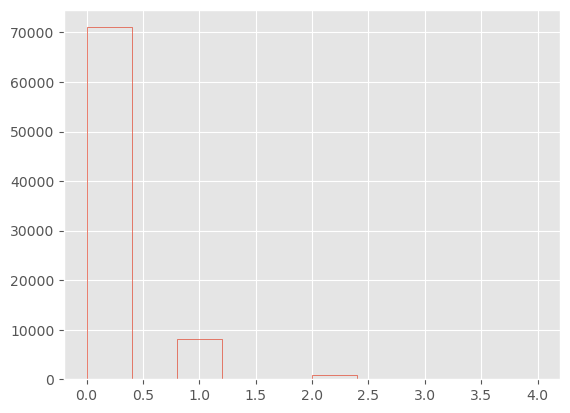

In [42]:
counts, bins = np.histogram(y_train['count_claim_amount'])
plt.stairs(counts, bins)

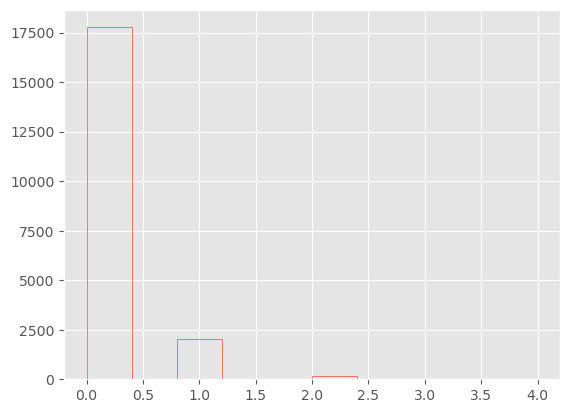

In [43]:
counts, bins = np.histogram(y_test['count_claim_amount'])
plt.stairs(counts, bins)

In [44]:
dist_y_train = y_train['count_claim_amount'].value_counts(normalize=True)
dist_y_train

0.0    0.888136
1.0    0.100714
2.0    0.010138
3.0    0.000913
4.0    0.000100
Name: count_claim_amount, dtype: float64

In [45]:
dist_y_test = y_test['count_claim_amount'].value_counts(normalize=True)
dist_y_test

0.0    0.88835
1.0    0.10150
2.0    0.00895
3.0    0.00115
4.0    0.00005
Name: count_claim_amount, dtype: float64

Comprobemos ahora que siguen una distribución de Poisson

In [46]:
mu = np.mean(y_train)
dist_poisson = np.array([stats.poisson.pmf(k=0, mu=mu)[0],
                         stats.poisson.pmf(k=1, mu=mu)[0],
                         stats.poisson.pmf(k=2, mu=mu)[0],
                         stats.poisson.pmf(k=3, mu=mu)[0],
                         stats.poisson.pmf(k=4, mu=mu)[0],
                         stats.poisson.pmf(k=5, mu=mu)[0]])

stats.chisquare(np.append(np.array(dist_y_train),0),dist_poisson)

In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'


Power_divergenceResult(statistic=0.004753594546258599, pvalue=0.9999999172692633)

In [47]:
mu = np.mean(y_test)

stats.chisquare(np.append(np.array(dist_y_test),0),dist_poisson)

Power_divergenceResult(statistic=0.004183763937360179, pvalue=0.9999999398663103)

In [48]:
dist_y = y['count_claim_amount'].value_counts(normalize=True)
dist_y

0.0    0.888179
1.0    0.100871
2.0    0.009900
3.0    0.000960
4.0    0.000090
Name: count_claim_amount, dtype: float64

In [49]:
mu = np.mean(y['count_claim_amount'])

stats.chisquare(np.append(np.array(dist_y),0), dist_poisson)

Power_divergenceResult(statistic=0.004527710353778977, pvalue=0.9999999267440048)

In [50]:
mu

0.12391123911239113

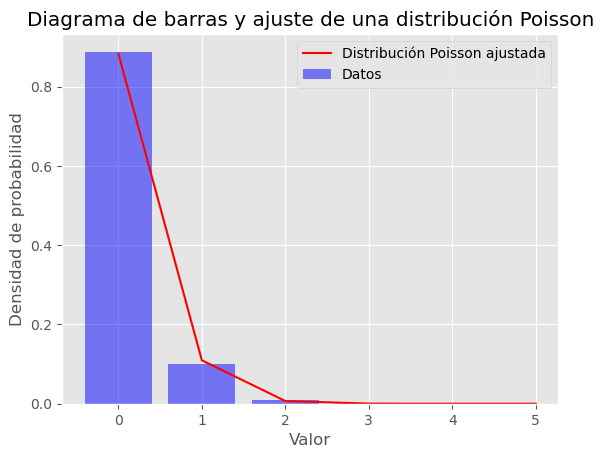

In [51]:
# 1. Visualiza el histograma de los datos
plt.bar(dist_y.index.values, dist_y, alpha=0.5, color='blue', label='Datos')

# 2. Ajusta una distribución Poisson a los datos
mu = np.mean(y['count_claim_amount'])

# 3. Grafica la distribución gamma ajustada
x_plot = np.linspace(0, 5, 6)  # Define el rango de valores en el eje x
distribucion_ajustada = poisson(mu)
y_plot = distribucion_ajustada.pmf(x_plot)
plt.plot(x_plot, y_plot, 'r-', label='Distribución Poisson ajustada')

# Ajusta los límites del eje x
# plt.xlim(0, 20000)

# Añade etiquetas y título al gráfico
plt.xlabel('Valor')
plt.ylabel('Densidad de probabilidad')
plt.title('Diagrama de barras y ajuste de una distribución Poisson')
plt.legend()

# Muestra el gráfico
plt.show()

In [52]:
dist_y

0.0    0.888179
1.0    0.100871
2.0    0.009900
3.0    0.000960
4.0    0.000090
Name: count_claim_amount, dtype: float64

In [53]:
dist_poisson

array([8.83268055e-01, 1.09637018e-01, 6.80443247e-03, 2.81536913e-04,
       8.73655153e-06, 2.16887603e-07])

# Estimación de E[N]

## GLM Poisson

In [54]:
# Aplicamos una GLM Poisson

modelo_glm_Poisson = sm.GLM(y_train['count_claim_amount'], sm.add_constant(X_train), family=sm.families.Poisson())
resultado_modelo_glm_Poisson = modelo_glm_Poisson.fit()
y_pred_glm_Poisson_train = resultado_modelo_glm_Poisson.predict(sm.add_constant(X_train))
y_pred_glm_Poisson_test = resultado_modelo_glm_Poisson.predict(sm.add_constant(X_test))

In [55]:
mean_squared_error(y_train['count_claim_amount'], np.full(len(y_train), np.mean(y_train['count_claim_amount'])))

0.13566948765349296

In [56]:
mean_squared_error(y_train['count_claim_amount'], y_pred_glm_Poisson_train)

0.13271491035505714

In [57]:
mean_squared_error(y_test['count_claim_amount'], np.full(len(y_test), np.mean(y_train['count_claim_amount'])))

0.13330985646330845

In [58]:
mean_squared_error(y_test['count_claim_amount'], y_pred_glm_Poisson_test)

0.1303170127925368

In [59]:
sum(y_train['count_claim_amount'])

9930.0

In [60]:
sum(y_pred_glm_Poisson_train)

9930.000000641103

In [61]:
sum(y_test['count_claim_amount'])

2461.0

In [62]:
sum(y_pred_glm_Poisson_test)

2492.2581642715695

In [63]:
np.mean(y_train['mean_claim_amount'])

112.6832289049449

In [64]:
np.mean(y_test['mean_claim_amount'])

111.60526358333314

In [65]:
np.mean(y_train[y_train['mean_claim_amount'] > 0]['mean_claim_amount'])

1007.3243523484956

In [66]:
np.mean(y_test[y_test['mean_claim_amount'] > 0]['mean_claim_amount'])

999.5993155694863

In [67]:
np.mean(pg17trainclaim['claim_amount'])

998.3147445726694

In [68]:
sum(y_train['count_claim_amount'] * y_train['mean_claim_amount'])

9918618.080000013

In [69]:
sum(y_pred_glm_Poisson_train * np.full(len(y_train), np.mean(y_train[y_train['mean_claim_amount'] > 0]['mean_claim_amount'])))

10002730.819466285

In [70]:
sum(y_test['count_claim_amount'] * y_test['mean_claim_amount'])

2451499.919999997

In [71]:
sum(y_pred_glm_Poisson_test * np.full(len(y_test), np.mean(y_test[y_test['mean_claim_amount'] > 0]['mean_claim_amount'])))

2491259.5552283386

### Interpretabilidad de GLM Poisson

In [264]:
# Función para obtener la atribución local de una GLM con función de enlace logarítmica

def atrib_local_GLM(model, X):
    
    # Obtención de los coeficientes
    coef_GLM_Poisson = model.params
    
    # Cálculo de atribución local
    rr = np.exp(coef_GLM_Poisson*X)
    atrib = np.sign(rr-1)*((rr-1)**2)
    return atrib
    
# Función para obtener el orden de mayor a menor de un vector ordenando por su valor abosoluto

def get_order_list(atrib):
    
    # Cálculo del orden por valor absoluto
    atrib_neg = -abs(atrib)
    orden_arg = np.argsort(atrib_neg)
    orden = atrib_neg.copy()
    orden[orden_arg] = np.arange(len(atrib)) + 1
    orden.sort_index()
    return orden

# Use SHAP values to show the effect of each feature of a given patient

def Kernel_SHAP_shap_values(model, train_data, n_sample, explain_data):
    # Create object that can calculate shap values
    if n_sample == 0:
        explainer = shap.KernelExplainer(model, train_data)
    else:
        explainer = shap.KernelExplainer(model, train_data[0:n_sample-1])
    return explainer.shap_values(explain_data), explainer

# Use SHAP values to show the effect of each feature of a given patient

def shap_force_plot(expected_value, shap_values, explain_data):
    shap.initjs()
    return shap.force_plot(expected_value, shap_values, explain_data, matplotlib=True)

# Función para obtener predicciones del modelo GLM de Poisson

def resultado_modelo_glm_Poisson_wrapper(X):
    return resultado_modelo_glm_Poisson.predict(X)

def shap_waterfall_plot(shap_explainer, X_test, interp_index, n_sample, feature_names, n_features_plot):
    if n_sample == 0:
        sample_shap = X_test
    else:
        sample_shap = X_test[0:n_sample-1]
    sv_glm = shap_explainer(sample_shap)
    expl = shap.Explanation(sv_glm, sv_glm.base_values, sample_shap, feature_names=feature_names)
    return shap.waterfall_plot(expl[interp_index], n_features_plot)

In [73]:
# Entrada que deseamos interpretar

X_interpret_count_1 = sm.add_constant(X_test).iloc[1]
X_interpret_count_1_np = np.array(X_interpret_count_1)
X_interpret_count_1

const                           1.0
pol_bonus                       0.5
pol_duration                    9.0
pol_sit_duration                5.0
drv_age1                       54.0
drv_age2                        0.0
drv_age_lic1                   35.0
drv_age_lic2                    0.0
vh_age                         13.0
vh_cyl                       1149.0
vh_din                         59.0
vh_sale_begin                  13.0
vh_sale_end                    11.0
vh_speed                      160.0
vh_value                    10962.0
vh_weight                     890.0
pol_insee_density               1.0
pol_coverage_Maxi               0.0
pol_coverage_Median1            0.0
pol_coverage_Median2            1.0
pol_coverage_Mini               0.0
pol_pay_freq_Biannual           0.0
pol_pay_freq_Monthly            1.0
pol_pay_freq_Quarterly          0.0
pol_pay_freq_Yearly             0.0
pol_payd_No                     1.0
pol_payd_Yes                    0.0
pol_usage_AllTrips          

In [186]:
# Otra forma de asegurar la predicción

resultado_modelo_glm_Poisson.predict(sm.add_constant(X_test).iloc[1])[0]

0.08027313125104872

In [76]:
# Interpretación local directa, vemos que cuadra con la total

np.exp(np.dot(coef_GLM_Poisson, X_interpret_count_1))

0.08027313125104872

In [152]:
np.prod(np.exp(coef_GLM_Poisson*X_interpret_count_1))

0.08027313125104871

In [265]:
atrib_1 = atrib_local_GLM(resultado_modelo_glm_Poisson, X_interpret_count_1)
orden_1 = get_order_list(atrib_1)

In [266]:
atrib_1

const                      -0.329464
pol_bonus                   0.189257
pol_duration               -0.000797
pol_sit_duration           -0.003921
drv_age1                    0.374643
drv_age2                    0.000000
drv_age_lic1               -0.016415
drv_age_lic2                0.000000
vh_age                     -0.079786
vh_cyl                      0.042405
vh_din                     -0.001180
vh_sale_begin              -0.023987
vh_sale_end                 0.001076
vh_speed                    0.119141
vh_value                    0.001373
vh_weight                  -0.000237
pol_insee_density          -0.000486
pol_coverage_Maxi           0.000000
pol_coverage_Median1        0.000000
pol_coverage_Median2       -0.000112
pol_coverage_Mini           0.000000
pol_pay_freq_Biannual       0.000000
pol_pay_freq_Monthly       -0.031309
pol_pay_freq_Quarterly      0.000000
pol_pay_freq_Yearly         0.000000
pol_payd_No                -0.064106
pol_payd_Yes                0.000000
p

In [210]:
orden_1

const                        2.0
pol_bonus                    3.0
pol_duration                20.0
pol_sit_duration            16.0
drv_age1                     1.0
drv_age2                    45.0
drv_age_lic1                14.0
drv_age_lic2                44.0
vh_age                       9.0
vh_cyl                      11.0
vh_din                      18.0
vh_sale_begin               13.0
vh_sale_end                 19.0
vh_speed                     6.0
vh_value                    17.0
vh_weight                   22.0
pol_insee_density           21.0
pol_coverage_Maxi           43.0
pol_coverage_Median1        42.0
pol_coverage_Median2        23.0
pol_coverage_Mini           41.0
pol_pay_freq_Biannual       40.0
pol_pay_freq_Monthly        12.0
pol_pay_freq_Quarterly      33.0
pol_pay_freq_Yearly         38.0
pol_payd_No                 10.0
pol_payd_Yes                37.0
pol_usage_AllTrips          36.0
pol_usage_Professional      35.0
pol_usage_Retired           34.0
pol_usage_

In [222]:
glm_Poisson_shap_values, glm_Poisson_explainer = Kernel_SHAP_shap_values(resultado_modelo_glm_Poisson_wrapper, sm.add_constant(X_train), 10000, np.array(X_interpret_count_1))

Using 10000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [231]:
glm_Poisson_shap_values

array([ 0.00000000e+00, -2.89224730e-03,  4.39862301e-04, -3.59644187e-03,
       -6.04924946e-04,  7.33116061e-03, -9.04149083e-04, -1.31636531e-03,
       -1.27768153e-02, -8.84338279e-03,  2.08201497e-03, -3.91793545e-03,
        1.17468091e-03, -2.66237864e-03, -2.63709534e-03,  3.85267556e-04,
        5.34100231e-03, -1.63361308e-02,  1.28956385e-04, -7.68531104e-04,
        4.50597456e-03,  8.10431631e-03, -1.42027111e-02,  4.40894914e-04,
        1.18681036e-02, -1.15795872e-03,  2.20594979e-03,  7.75177743e-05,
        2.03382257e-03,  1.26735335e-02, -1.37966523e-02, -2.53688551e-02,
        2.87637079e-02, -4.78481338e-03, -2.84853943e-03,  1.56929776e-02,
       -2.78934631e-02,  7.53056581e-05,  3.65396867e-03, -4.28551986e-03,
        2.19100233e-04,  9.48982117e-05, -5.75289017e-03,  3.49045571e-04,
        4.79020339e-04,  4.94412668e-03,  5.91822644e-04])

In [235]:
glm_Poisson_explainer.expected_value

0.1239639007834776

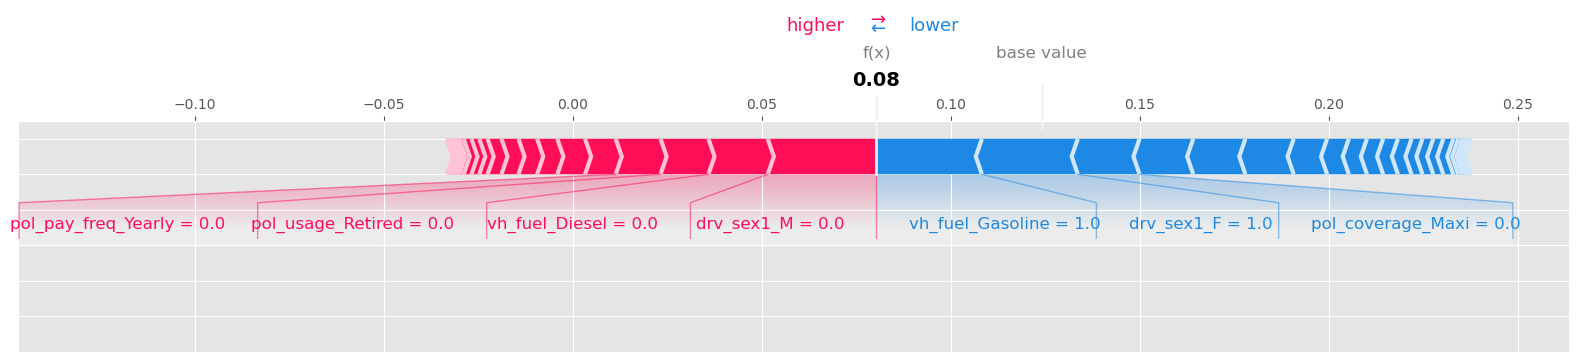

In [234]:
shap_force_plot(glm_Poisson_explainer.expected_value, glm_Poisson_shap_values, X_interpret_count_1)

In [240]:
# Reducimos el número de iteraciones para que la máquina lo pueda soportar

glm_Poisson_shap_values_low, glm_Poisson_explainer_low = Kernel_SHAP_shap_values(resultado_modelo_glm_Poisson_wrapper, sm.add_constant(X_train), 100, np.array(X_interpret_count_1))

  0%|          | 0/9 [00:00<?, ?it/s]

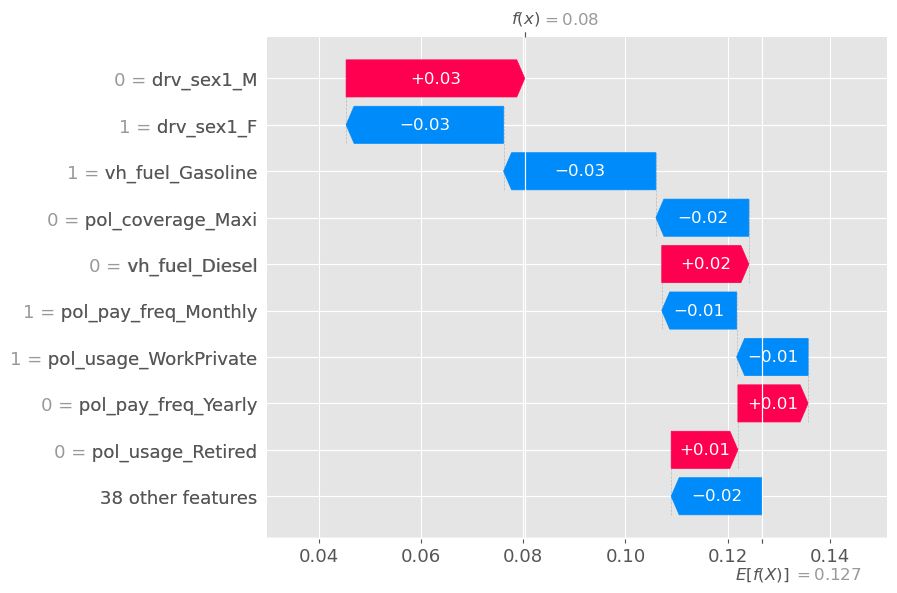

In [242]:
shap_waterfall_plot(glm_Poisson_explainer_low, sm.add_constant(X_test), 1, 10, X_interpret_count_1.index.tolist(), 10)

In [269]:
# Comparación de resultados de interpretabilidad de atribución local directa contra KernelSHAP

glm_Poisson_shap_values_feat = atrib_1.copy()
glm_Poisson_shap_values_feat[0:len(glm_Poisson_shap_values_feat)] = glm_Poisson_shap_values
orden_shap = get_order_list(glm_Poisson_shap_values_feat)

compare_GLM_Poisson_results = pd.DataFrame({'Atrib. local': atrib_1, 'Ord Atrib. local': orden_1, 'SHAP values': glm_Poisson_shap_values_feat, 'Ord SHAP values': orden_shap})
compare_GLM_Poisson_results.sort_values(by='Ord Atrib. local')


,Atrib. local,Ord Atrib. local,SHAP values,Ord SHAP values
drv_age1,0.374643,1.0,-0.000605,35.0
const,-0.329464,2.0,0.000000,47.0
pol_bonus,0.189257,3.0,-0.002892,23.0
vh_type_Tourism,-0.136479,4.0,-0.004286,19.0
vh_fuel_Gasoline,-0.129197,5.0,-0.027893,2.0
vh_speed,0.119141,6.0,-0.002662,25.0
drv_sex1_F,-0.111205,7.0,-0.025369,3.0
pol_usage_WorkPrivate,-0.096448,8.0,-0.013797,7.0
vh_age,-0.079786,9.0,-0.012777,8.0
pol_payd_No,-0.064106,10.0,-0.001158,32.0


## GLM Gamma

In [ ]:
# import numpy as np
# from scipy.stats import gamma
# import matplotlib.pyplot as plt

# Supongamos que tienes un conjunto de datos llamado `data`
data = pg17trainclaim['claim_amount']

# 1. Visualiza el histograma de los datos
plt.hist(data, bins=1000, density=True, alpha=0.5, color='blue', label='Datos')

# 2. Ajusta una distribución gamma a los datos
# shape, loc, scale = gamma.fit(data)
shape = 1
loc = 0
scale = np.mean(pg17trainclaim['claim_amount'])/shape

# 3. Grafica la distribución gamma ajustada
x_plot = np.linspace(0, 20000, 1000)  # Define el rango de valores en el eje x
distribucion_ajustada = gamma(shape, loc=loc, scale=scale)
y_plot = distribucion_ajustada.pdf(x_plot)
plt.plot(x_plot, y_plot, 'r-', label='Distribución Gamma ajustada')

# Ajusta los límites del eje x
plt.xlim(0, 8000)

# Añade etiquetas y título al gráfico
plt.xlabel('Valor')
plt.ylabel('Densidad de probabilidad')
plt.title('Histograma y ajuste de una distribución Gamma')
plt.legend()

# Muestra el gráfico
plt.show()

In [ ]:
# Supongamos que data es tu conjunto de datos
data = pg17trainclaim['claim_amount']

# Ajusta una distribución gamma a los datos
E = np.mean(pg17trainclaim['claim_amount'])
V = np.var(pg17trainclaim['claim_amount'])

shape = 1
loc = 0
scale = np.mean(pg17trainclaim['claim_amount'])/shape

# Realiza el test de Kolmogorov-Smirnov
resultado_ks = kstest(data, 'gamma', args=(shape, loc, scale))
print("Estadístico KS:", resultado_ks.statistic)
print("Valor p:", resultado_ks.pvalue)

In [ ]:
shape, loc, scale

In [ ]:
# import numpy as np
# from scipy.stats import gamma
# import matplotlib.pyplot as plt

# Supongamos que tienes un conjunto de datos llamado `data`
data = pg17trainclaim['claim_amount']

# 1. Visualiza el histograma de los datos
plt.hist(data, bins=2000, density=True, alpha=0.5, color='blue', label='Datos')

# 2. Ajusta una distribución gamma a los datos
# shape, loc, scale = gamma.fit(data)

# E = np.mean(pg17trainclaim['claim_amount'])
# V = np.var(pg17trainclaim['claim_amount'])

# shape = E**2/V
# loc = 0
# scale = V/E

# shape = 1
# loc = 0
# scale = np.mean(pg17trainclaim['claim_amount'])/shape


scale = np.mean(pg17trainclaim['claim_amount'])
shape = 1
loc = 0

# 3. Grafica la distribución gamma ajustada
x_plot = np.linspace(0, 5000, 1000)  # Define el rango de valores en el eje x
distribucion_ajustada = gamma(shape, loc=loc, scale=scale)
y_plot = distribucion_ajustada.pdf(x)
plt.plot(x_plot, y_plot, 'r-', label='Distribución Gamma ajustada')

# Ajusta los límites del eje x
plt.xlim(0, 5000)
plt.ylim(0, 0.002)

# Añade etiquetas y título al gráfico
plt.xlabel('Valor')
plt.ylabel('Densidad de probabilidad')
plt.title('Histograma y ajuste de una distribución Gamma')
plt.legend()

# Muestra el gráfico
plt.show()

In [ ]:
# Supongamos que data es tu conjunto de datos
data = pg17trainclaim['claim_amount']

# Ajusta una distribución gamma a los datos
# E = np.mean(pg17trainclaim['claim_amount'])
# V = np.var(pg17trainclaim['claim_amount'])

# shape = E**2/V
# loc = 0
# scale = V/E

scale = np.mean(pg17trainclaim['claim_amount'])
shape = 1
loc = 0

# Realiza el test de Kolmogorov-Smirnov
resultado_ks = kstest(data, 'gamma', args=(shape, loc, scale))
print("Estadístico KS:", resultado_ks.statistic)
print("Valor p:", resultado_ks.pvalue)

In [ ]:
np.mean(pg17trainclaim['claim_amount'])

In [ ]:
# import numpy as np
# from scipy.stats import gamma
# import matplotlib.pyplot as plt

# Supongamos que tienes un conjunto de datos llamado `data`
data = pg17trainclaim['claim_amount']

# 1. Visualiza el histograma de los datos
plt.hist(data, bins=1000, density=True, alpha=0.5, color='blue', label='Datos')

# 2. Ajusta una distribución gamma a los datos
loc = 0
scale = np.mean(pg17trainclaim['claim_amount'])

# 3. Grafica la distribución gamma ajustada
x_plot = np.linspace(0, 20000, 1000)  # Define el rango de valores en el eje x
distribucion_ajustada = expon(loc=loc, scale=scale)
y_plot = distribucion_ajustada.pdf(x)
plt.plot(x_plot, y_plot, 'r-', label='Distribución Exponencial ajustada')

# Ajusta los límites del eje x
plt.xlim(0, 20000)

# Añade etiquetas y título al gráfico
plt.xlabel('Valor')
plt.ylabel('Densidad de probabilidad')
plt.title('Histograma y ajuste de una distribución Exponencial')
plt.legend()

# Muestra el gráfico
plt.show()

In [ ]:
# Supongamos que data es tu conjunto de datos
data = pg17trainclaim['claim_amount']

# Ajusta una distribución eponencial a los datos
loc = 0
scale = np.mean(pg17trainclaim['claim_amount'])

# Realiza el test de Kolmogorov-Smirnov
resultado_ks = kstest(data, 'expon', args=(loc, scale))
print("Estadístico KS:", resultado_ks.statistic)
print("Valor p:", resultado_ks.pvalue)

In [ ]:
# import numpy as np
# from scipy.stats import gamma
# import matplotlib.pyplot as plt

# Supongamos que tienes un conjunto de datos llamado `data`
data = y[y['mean_claim_amount'] > 0]['mean_claim_amount']

# 1. Visualiza el histograma de los datos
plt.hist(data, bins=2000, density=True, alpha=0.5, color='blue', label='Datos')

# 2. Ajusta una distribución gamma a los datos
# shape, loc, scale = gamma.fit(data)

shape = 1
scale = np.mean(data)*2
loc = 0

# 3. Grafica la distribución gamma ajustada
x_plot = np.linspace(0, 5000, 1000)  # Define el rango de valores en el eje x
distribucion_ajustada = gamma(shape, loc=loc, scale=scale)
y_plot = distribucion_ajustada.pdf(x_plot)
plt.plot(x_plot, y_plot, 'r-', label='Distribución Gamma ajustada')

# Ajusta los límites del eje x
plt.xlim(0, 5000)
plt.ylim(0, 0.002)

# Añade etiquetas y título al gráfico
plt.xlabel('Valor')
plt.ylabel('Densidad de probabilidad')
plt.title('Histograma y ajuste de una distribución Gamma')
plt.legend()

# Muestra el gráfico
plt.show()

In [ ]:
y[y['mean_claim_amount'] > 0]

In [ ]:
pg17trainclaim.sort_values('claim_amount').head(20)

In [ ]:
pg17trainclaim.sort_values('claim_amount', ascending=False).head(20)

In [ ]:
distribucion_ajustada.mean()

In [ ]:
np.mean(pg17trainclaim['claim_amount'])

In [ ]:
np.mean(data)

Aplicamos el GLM Gamma por si las moscas

In [ ]:
# Aplicamos una GLM Gamma

modelo_glm_Gamma = sm.GLM(y_train[y_train['mean_claim_amount'] > 0]['mean_claim_amount'], sm.add_constant(X_train[y_train['mean_claim_amount'] > 0]), family=sm.families.Gamma(sm.families.links.Log()))
resultado_modelo_glm_Gamma = modelo_glm_Gamma.fit()
y_pred_glm_Gamma_train = resultado_modelo_glm_Gamma.predict(sm.add_constant(X_train))
y_pred_glm_Gamma_test = resultado_modelo_glm_Gamma.predict(sm.add_constant(X_test))

In [ ]:
# Error con la media
mean_squared_error(y_train[y_train['mean_claim_amount'] > 0]['mean_claim_amount'], np.full(len(y_train[y_train['mean_claim_amount'] > 0]), np.mean(y_train[y_train['mean_claim_amount'] > 0]['mean_claim_amount'])))

In [ ]:
# Error de train con GLM
mean_squared_error(y_train[y_train['mean_claim_amount'] > 0]['mean_claim_amount'], y_pred_glm_Gamma_train[y_train['mean_claim_amount'] > 0])

In [ ]:
# Error de test con GLM
mean_squared_error(y_test[y_test['mean_claim_amount'] > 0]['mean_claim_amount'], y_pred_glm_Gamma_test[y_test['mean_claim_amount'] > 0])

In [ ]:
# Error de todos los claims contrastando con media
mean_squared_error(y_train['mean_claim_amount'], np.full(len(y_train), np.mean(y_train[y_train['mean_claim_amount'] > 0]['mean_claim_amount'])))

In [ ]:
# Error de todos los claims con GLM train
mean_squared_error(y_train['mean_claim_amount'], y_pred_glm_Gamma_train)

In [ ]:
# Error de todos los claims con GLM test
mean_squared_error(y_test['mean_claim_amount'], y_pred_glm_Gamma_test)

In [ ]:
# Error de los claims > 0 contrastando con media
mean_squared_error(y_train[y_train['mean_claim_amount'] > 0]['mean_claim_amount'], np.full(len(y_train[y_train['mean_claim_amount'] > 0]), np.mean(y_train[y_train['mean_claim_amount'] > 0]['mean_claim_amount'])))

In [ ]:
# Error de los claims > 0 con GLM train
mean_squared_error(y_train[y_train['mean_claim_amount'] > 0]['mean_claim_amount'], y_pred_glm_Gamma_train[y_train['mean_claim_amount'] > 0])

In [ ]:
# Error de los claims > 0 contrastando con media en test
mean_squared_error(y_test[y_test['mean_claim_amount'] > 0]['mean_claim_amount'], np.full(len(y_test[y_test['mean_claim_amount'] > 0]), np.mean(y_train[y_train['mean_claim_amount'] > 0]['mean_claim_amount'])))

In [ ]:
# Error de los claims > 0 con GLM test
mean_squared_error(y_test[y_test['mean_claim_amount'] > 0]['mean_claim_amount'], y_pred_glm_Gamma_test[y_test['mean_claim_amount'] > 0])

In [ ]:
# Supongamos que tienes un conjunto de datos llamado `data`
data = y_train[y_train['mean_claim_amount'] > 0]['mean_claim_amount']

# 1. Visualiza el histograma de los datos
plt.hist(data, bins=2000, density=True, alpha=0.5, color='blue', label='Datos')

# Ajusta los límites del eje x
plt.xlim(0, 5000)
plt.ylim(0, 0.002)

In [ ]:
# Supongamos que tienes un conjunto de datos llamado `data`
data = y_test[y_test['mean_claim_amount'] > 0]['mean_claim_amount']

# 1. Visualiza el histograma de los datos
plt.hist(data, bins=2000, density=True, alpha=0.5, color='blue', label='Datos')

# Ajusta los límites del eje x
plt.xlim(0, 5000)
plt.ylim(0, 0.002)

In [ ]:
# Supongamos que tienes un conjunto de datos llamado `data`
data = y_train[y_train['mean_claim_amount'] > 0]['mean_claim_amount']

# 1. Visualiza el histograma de los datos
plt.hist(data, bins=2000, density=True, alpha=0.5, color='blue', label='Datos train')

# Supongamos que tienes un conjunto de datos llamado `data`
data = y_test[y_test['mean_claim_amount'] > 0]['mean_claim_amount']

# 1. Visualiza el histograma de los datos
plt.hist(data, bins=2000, density=True, alpha=0.5, color='green', label='Datos test')

# Ajusta los límites del eje x
plt.xlim(0, 5000)
plt.ylim(0, 0.002)

## GLM Gamma particionado

In [ ]:
# import numpy as np
# from scipy.stats import gamma
# import matplotlib.pyplot as plt

# Supongamos que tienes un conjunto de datos llamado `data`
data =  y[y['mean_claim_amount']>0]['mean_claim_amount']

# 1. Visualiza el histograma de los datos
plt.hist(data, bins=2000, density=True, alpha=0.5, color='blue', label='Datos')

# 2. Ajusta una distribución gamma a los datos
# shape, loc, scale = gamma.fit(data)

E = np.mean(data)
V = np.var(data)

shape = (E**2)/V
loc = 0
scale = V/E

# 3. Grafica la distribución gamma ajustada
x_plot = np.linspace(0, 5000, 1000)  # Define el rango de valores en el eje x
distribucion_ajustada = gamma(shape, loc=loc, scale=scale)
y_plot = distribucion_ajustada.pdf(x_plot)
plt.plot(x_plot, y_plot, 'r-', label='Distribución Gamma ajustada')

# Ajusta los límites del eje x
plt.xlim(0, 5000)
plt.ylim(0, 0.002)

# Añade etiquetas y título al gráfico
plt.xlabel('Valor')
plt.ylabel('Densidad de probabilidad')
plt.title('Histograma y ajuste de una distribución Gamma')
plt.legend()

# Muestra el gráfico
plt.show()

# Realiza el test de Kolmogorov-Smirnov
resultado_ks = kstest(data, 'gamma', args=(shape, loc, scale))
print("Estadístico KS:", resultado_ks.statistic)
print("Valor p:", resultado_ks.pvalue)

In [ ]:
# import numpy as np
# from scipy.stats import gamma
# import matplotlib.pyplot as plt

corte = 20

# Supongamos que tienes un conjunto de datos llamado `data`
data =  y[(y['mean_claim_amount']>0) & (y['mean_claim_amount']<=corte)]['mean_claim_amount']

# 1. Visualiza el histograma de los datos
plt.hist(data, bins=20, density=True, alpha=0.5, color='blue', label='Datos')

# 2. Ajusta una distribución gamma a los datos
shape, loc, scale = gamma.fit(data)

# E = np.mean(data)
# V = np.var(data)

# shape = (E**2)/V
# loc = 0
# scale = V/E

# 3. Grafica la distribución gamma ajustada
x_plot = np.linspace(0, 5000, 1000)  # Define el rango de valores en el eje x
# x_plot = np.linspace(0, corte, 1000)  # Define el rango de valores en el eje x
distribucion_ajustada = gamma(shape, loc=loc, scale=scale)
y_plot = distribucion_ajustada.pdf(x_plot)
plt.plot(x_plot, y_plot, 'r-', label='Distribución Gamma ajustada')

# Ajusta los límites del eje x
plt.xlim(0, corte)
# plt.ylim(0, 0.002)

# Añade etiquetas y título al gráfico
plt.xlabel('Valor')
plt.ylabel('Densidad de probabilidad')
plt.title('Histograma y ajuste de una distribución Gamma')
plt.legend()

# Muestra el gráfico
plt.show()

# Realiza el test de Kolmogorov-Smirnov
resultado_ks = kstest(data, 'gamma', args=(shape, loc, scale))
print("Estadístico KS:", resultado_ks.statistic)
print("Valor p:", resultado_ks.pvalue)

In [ ]:
shape, loc, scale

In [ ]:
shape, loc, scale

In [ ]:
len(data)

In [ ]:
# import numpy as np
# from scipy.stats import gamma
# import matplotlib.pyplot as plt

corte_bajo = 20
corte_alto = 200

# Supongamos que tienes un conjunto de datos llamado `data`
data =  y[(y['mean_claim_amount']>corte_bajo) & (y['mean_claim_amount']<=corte_alto)]['mean_claim_amount']

# 1. Visualiza el histograma de los datos
plt.hist(data, bins=50, density=True, alpha=0.5, color='blue', label='Datos')

# 2. Ajusta una distribución gamma a los datos
# shape, loc, scale = gamma.fit(data)

E = np.mean(data)
V = np.var(data)

shape = (E**2)/V
loc = 0
scale = V/E

# 3. Grafica la distribución gamma ajustada
x_plot = np.linspace(corte_bajo, corte_alto, 1000)  # Define el rango de valores en el eje x
# x_plot = np.linspace(0, corte, 1000)  # Define el rango de valores en el eje x
distribucion_ajustada = gamma(shape, loc=loc, scale=scale)
y_plot = distribucion_ajustada.pdf(x_plot)
plt.plot(x_plot, y_plot, 'r-', label='Distribución Gamma ajustada')

# Ajusta los límites del eje x
plt.xlim(corte_bajo, corte_alto)
# plt.ylim(0, 0.002)

# Añade etiquetas y título al gráfico
plt.xlabel('Valor')
plt.ylabel('Densidad de probabilidad')
plt.title('Histograma y ajuste de una distribución Gamma')
plt.legend()

# Muestra el gráfico
plt.show()

# Realiza el test de Kolmogorov-Smirnov
resultado_ks = kstest(data, 'gamma', args=(shape, loc, scale))
print("Estadístico KS:", resultado_ks.statistic)
print("Valor p:", resultado_ks.pvalue)

In [ ]:
len(data)

In [121]:
%store pg17trainpol
%store pg17trainclaim
%store y
%store X
%store X_train
%store X_test
%store y_train
%store y_test
%store DensidadPoblacion
%store pg17trainpoldens
%store vh_make_group_dic
%store pg17trainclaim_group
%store pg17trainpolclaims
%store pg17trainpolclaims_pre
%store pg17trainpolclaims_pre2
%store pg17trainpolclaims_dum
%store dist_y_train
%store dist_y_test
%store dist_y
%store modelo_glm_Poisson
%store resultado_modelo_glm_Poisson
%store y_pred_glm_Poisson_train
%store y_pred_glm_Poisson_test
%store modelo_glm_Gamma
%store resultado_modelo_glm_Gamma
%store y_pred_glm_Gamma_train
%store y_pred_glm_Gamma_test
%store glm_Poisson_shap_values
# %store glm_Poisson_explainer

Stored 'pg17trainpol' (DataFrame)
Stored 'pg17trainclaim' (DataFrame)
Stored 'y' (DataFrame)
Stored 'X' (DataFrame)
Stored 'X_train' (DataFrame)
Stored 'X_test' (DataFrame)
Stored 'y_train' (DataFrame)
Stored 'y_test' (DataFrame)
Stored 'DensidadPoblacion' (DataFrame)
Stored 'pg17trainpoldens' (DataFrame)
Stored 'vh_make_group_dic' (dict)
Stored 'pg17trainclaim_group' (DataFrame)
Stored 'pg17trainpolclaims' (DataFrame)
Stored 'pg17trainpolclaims_pre' (DataFrame)
Stored 'pg17trainpolclaims_pre2' (DataFrame)
Stored 'pg17trainpolclaims_dum' (DataFrame)
Stored 'dist_y_train' (Series)
Stored 'dist_y_test' (Series)
Stored 'dist_y' (Series)
Stored 'modelo_glm_Poisson' (GLM)
Stored 'resultado_modelo_glm_Poisson' (GLMResultsWrapper)
Stored 'y_pred_glm_Poisson_train' (Series)
Stored 'y_pred_glm_Poisson_test' (Series)
Stored 'modelo_glm_Gamma' (GLM)
Stored 'resultado_modelo_glm_Gamma' (GLMResultsWrapper)
Stored 'y_pred_glm_Gamma_train' (Series)
Stored 'y_pred_glm_Gamma_test' (Series)
Stored 'glm_